# Supervised Sector Classification

Let's now use the features we constructed and the known sectors to build a supervised classification model. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
agreements_features = pd.read_pickle("classification_features.pkl")

For now, let's just build a model only on the completely labeled data, so if the project name or description is missing, we'll ignore it.

In [4]:
labeled_set = agreements_features.dropna(how='any',inplace=False,subset=['project_description_lsi','Project Name','project_name_lsi','sector_id'])
labeled_set = labeled_set.loc[labeled_set.project_name_lsi.apply(len) != 0]
labeled_set = labeled_set.loc[labeled_set.project_description_lsi.apply(len) != 0]

In [5]:
labeled_set.major_sector_name.value_counts()

Public Admin                   178
Transportation                 118
Water/Sanitation/Waste         116
Agriculture                    104
Energy and Extractives          79
Industry and Trade/Services     70
Education                       69
Health                          63
Social Protection               56
Financial Sector                47
Info and Communication           7
Name: major_sector_name, dtype: int64

"Info and Communication" only has 7 data points. We'll just drop it and train on the other 10 classes.

In [6]:
labeled_set = labeled_set.loc[labeled_set.major_sector_name != "Info and Communication"]
labeled_set.major_sector_name.value_counts()

Public Admin                   178
Transportation                 118
Water/Sanitation/Waste         116
Agriculture                    104
Energy and Extractives          79
Industry and Trade/Services     70
Education                       69
Health                          63
Social Protection               56
Financial Sector                47
Name: major_sector_name, dtype: int64

For features, we will use the year, the topic weights from the LSI topic model for both the project name and the project description, and also the computed similarities to the sector description.

In [7]:
desc_features = np.stack(labeled_set.project_description_lsi.to_numpy())[:,:100]
name_features = np.stack(labeled_set.project_name_lsi.to_numpy())[:,:100]
desc_distances = np.stack(labeled_set.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(labeled_set.project_name_similarities_lsi.to_numpy()).squeeze()
X_features = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1) 
y = labeled_set['sector_id'].apply(int).to_numpy().ravel()

In [8]:
#Get sector names
with open("../world_bank_sectors.txt") as f:
  sectors = f.read()

sectors_list = sectors.split("\n")

sector_dict = dict()
current_major_sector = ''
for sector in sectors_list:
    if sector == '':
        current_major_sector = ''
        continue
    if current_major_sector == '':
        current_major_sector = sector
        sector_dict[current_major_sector] = []
        continue
    if current_major_sector in sector_dict.keys():
        sector_dict[current_major_sector].append(sector)
sectors = list(sector_dict.keys())
sectors.pop(6) #remove the ignored sector

'Info and Communication'

We'll set aside 25% of the data as a test set.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features,y,train_size=0.75,stratify=y,random_state=52323)

Let's build some models.

In [10]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


## Random forest
Start with a random forest. Those typically work pretty well. We'll run a grid search over hyperparameters and choose the parameters with the best cross-validation accuracy.

In [11]:
rf_pred = ensemble.RandomForestClassifier(n_estimators=200,max_depth=7,class_weight="balanced",random_state=4252)
rf_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 7, 8, None],
    "ccp_alpha": [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
}
rf = GridSearchCV(estimator=rf_pred,param_grid=rf_grid,scoring=make_scorer(accuracy_score),n_jobs=4)

In [12]:
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=7, n_estimators=200,
                                              random_state=4252),
             n_jobs=4,
             param_grid={'ccp_alpha': [0.001, 0.002, 0.003, 0.004, 0.005,
                                       0.006],
                         'max_depth': [6, 7, 8, None],
                         'n_estimators': [200, 300, 400]},
             scoring=make_scorer(accuracy_score))

In [13]:
y_train_pred = rf.predict(X_train)
rf_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test,y_test_pred)
rf_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
rf_top2_test_acc = top_k_accuracy_score(y_test,rf.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(rf_train_acc,3))
print("Test Accuracy:", np.round(rf_test_acc,3))
print("Top 2 Test Accuracy:", np.round(rf_top2_test_acc,3))

Train Accuracy: 0.963
Test Accuracy: 0.716
Top 2 Test Accuracy: 0.84


In [14]:
rf.best_params_

{'ccp_alpha': 0.004, 'max_depth': None, 'n_estimators': 300}

<Figure size 720x720 with 0 Axes>

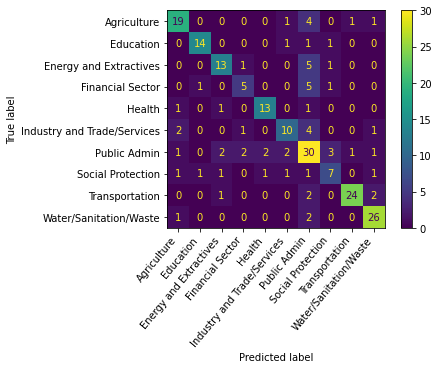

In [15]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

The model has the most problems with the Public Admin sector. That's kind of a vague category, and it's also the largest class. A lot of Public Admin projects have secondary sectors.

<Figure size 720x720 with 0 Axes>

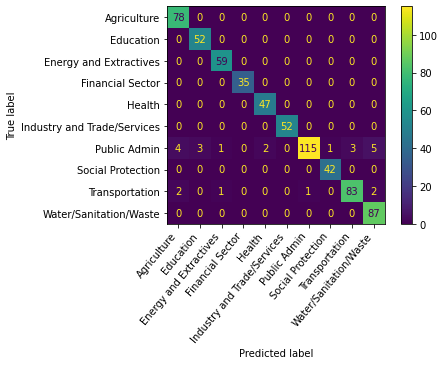

In [16]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Now replace the model with the best version.

In [17]:
rf = rf.best_estimator_

In [18]:
rf.feature_importances_.argsort()

array([193, 196, 170, 157,  49, 147,  53,  78, 154, 151,  71, 174, 172,
        43, 167, 163, 142, 164, 175,  59, 191, 186, 162, 165, 188, 198,
       137, 185, 199,  91,  40,  92, 150, 217,  93, 155,  85, 216,  25,
        45, 180,  46,  56, 169, 125,   0, 168, 160, 194, 153, 190, 179,
       122, 120, 166, 177,   2,  57, 100, 145,  87, 197,  95, 182,  75,
       130,  69, 183,  58, 184, 123,  66, 156, 178, 181,  70,  86,  76,
       143,  65, 139,  80, 140, 173, 187,  51,  74, 192,  73, 159,  47,
        50, 195,  22,  52, 148, 141, 189, 176,  21,  84,  62, 220, 138,
       132,  32,  79,  37,  88,  77,  67,  39, 152, 161,  90, 218, 171,
       128,  89, 134, 126,  36, 144,  99, 121,  94, 116, 114, 146, 158,
        23,  68,  83, 110,  42,  26,  30, 101,  64,  31, 115,  82,  35,
       112, 127, 129,  96,  14, 135,  63, 205, 207,  29,  33,  97, 149,
        17, 102,  28,  98,  72,  81, 203,   3, 206,  38, 131, 118,  16,
       119,  41, 113, 133,  18,  48,  15,  61, 103,   1, 136,  2

Interestingly, some of the most important features for the random forest are the topics explaining the least variance in the LSI model.

## Logistic Regression

In [19]:
lin = LogisticRegression(class_weight="balanced",C=1,penalty="elasticnet",l1_ratio=0.8,solver='saga',max_iter=5000, random_state=424)
logistic_grid = {
    "C": [0.1, 0.2, 0.5, 0.75, 1],
    "l1_ratio": [0.0, 0.2, 0.5, 0.8, 1.0]
}
logistic_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('logistic',GridSearchCV(estimator=lin,param_grid=logistic_grid,scoring=make_scorer(accuracy_score),n_jobs=4))
])
logistic_pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logistic',
                 GridSearchCV(estimator=LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           l1_ratio=0.8,
                                                           max_iter=5000,
                                                           penalty='elasticnet',
                                                           random_state=424,
                                                           solver='saga'),
                              n_jobs=4,
                              param_grid={'C': [0.1, 0.2, 0.5, 0.75, 1],
                                          'l1_ratio': [0.0, 0.2, 0.5, 0.8,
                                                       1.0]},
                              scoring=make_scorer(accuracy_score)))])

In [20]:
logistic_pipe['logistic'].best_params_

{'C': 0.1, 'l1_ratio': 0.2}

In [21]:
y_train_pred = logistic_pipe.predict(X_train)
log_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = logistic_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test,y_test_pred)
log_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
log_top2_test_acc = top_k_accuracy_score(y_test,logistic_pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(log_train_acc,3))
print("Test Accuracy:", np.round(log_test_acc,3))
print("Top 2 Test Accuracy:", np.round(log_top2_test_acc,3))

Train Accuracy: 0.874
Test Accuracy: 0.698
Top 2 Test Accuracy: 0.84


<Figure size 720x720 with 0 Axes>

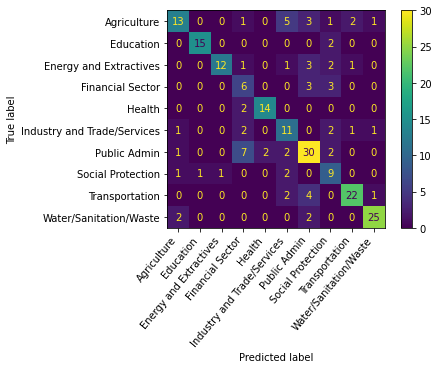

In [22]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(logistic_pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [23]:
logistic_est = logistic_pipe['logistic'].best_estimator_
logistic_pipe.steps.pop(1)
logistic_pipe.steps.append(('logistic',logistic_est))

## Support Vector Machine

In [24]:
svm = SVC(max_iter=5000,probability=True,class_weight="balanced",C=2,random_state=1212)
svm_grid = {
    "C": [0.5, 1, 2, 3, 5],
    "kernel": ['linear','rbf','poly']
}
pipe = Pipeline([('scale',StandardScaler()),('svm',GridSearchCV(estimator=svm,param_grid=svm_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('svm',
                 GridSearchCV(estimator=SVC(C=2, class_weight='balanced',
                                            max_iter=5000, probability=True,
                                            random_state=1212),
                              n_jobs=4,
                              param_grid={'C': [0.5, 1, 2, 3, 5],
                                          'kernel': ['linear', 'rbf', 'poly']},
                              scoring=make_scorer(accuracy_score)))])

In [25]:
y_train_pred = pipe.predict(X_train)
svm_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = pipe.predict(X_test)
svm_test_acc = accuracy_score(y_test,y_test_pred)
svm_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
svm_top2_test_acc = top_k_accuracy_score(y_test,pipe.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(svm_train_acc,3))
print("Test Accuracy:", np.round(svm_test_acc,3))
print("Top 2 Test Accuracy:", np.round(svm_top2_test_acc,3))

Train Accuracy: 0.942
Test Accuracy: 0.729
Top 2 Test Accuracy: 0.871


The SVM model does about as well as the random forest.

In [26]:
pipe['svm'].best_params_

{'C': 2, 'kernel': 'rbf'}

<Figure size 720x720 with 0 Axes>

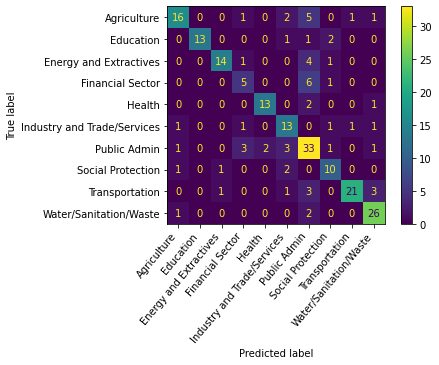

In [27]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

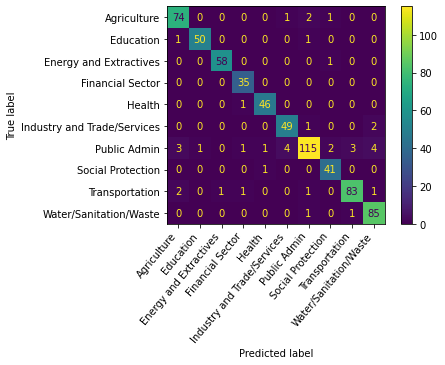

In [28]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [29]:
svm_est = pipe['svm'].best_estimator_
pipe.steps.pop(1)
pipe.steps.append(('svm',svm_est))

In [34]:
ens = VotingClassifier([
    ('rf',rf),
    ('logistic',logistic_pipe),
    ('svm',pipe),
],voting='soft',
weights=[0.4,0.2,0.4]) #weight the RF and SVM higher because they perform better than the logistic regression
ens.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(ccp_alpha=0.004,
                                                     class_weight='balanced',
                                                     n_estimators=300,
                                                     random_state=4252)),
                             ('logistic',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.2,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=424

In [35]:
y_train_pred = ens.predict(X_train)
ens_train_acc = accuracy_score(y_train,y_train_pred)
y_test_pred = ens.predict(X_test)
ens_test_acc = accuracy_score(y_test,y_test_pred)
ens_test_balanced_acc = balanced_accuracy_score(y_test,y_test_pred)
ens_top2_test_acc = top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=2)
print("Train Accuracy:", np.round(ens_train_acc,3))
print("Test Accuracy:", np.round(ens_test_acc,3))
print("Top 2 Test Accuracy:", np.round(ens_top2_test_acc,3))

Train Accuracy: 0.951
Test Accuracy: 0.764
Top 2 Test Accuracy: 0.871


In [36]:
top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=5)

0.9688888888888889

<Figure size 720x720 with 0 Axes>

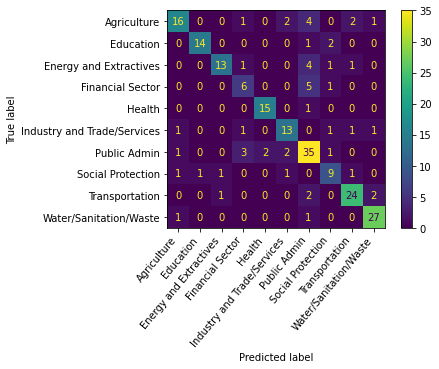

In [37]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(ens,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

Most misclassifications still have to do with Public Admin.

Let's use the ensemble model, as it's better than any of the individual models. To make predictions for the unlabeled data, we'll first fit it on the whole dataset.

In [38]:
ens.fit(X_features,y)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(ccp_alpha=0.004,
                                                     class_weight='balanced',
                                                     n_estimators=300,
                                                     random_state=4252)),
                             ('logistic',
                              Pipeline(steps=[('scale', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.2,
                                                                  max_iter=5000,
                                                                  penalty='elasticnet',
                                                                  random_state=424

In [39]:
y_pred = ens.predict(X_features)
accuracy_score(y,y_pred)

0.9366666666666666

<Figure size 720x720 with 0 Axes>

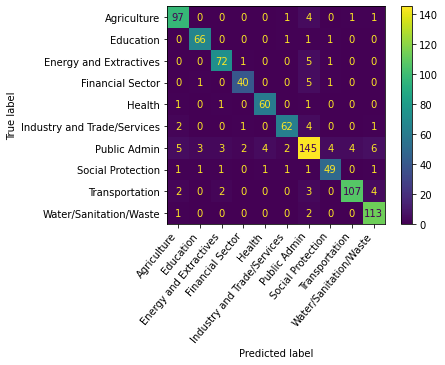

In [120]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_features,y,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [40]:
top_k_accuracy_score(y,rf.predict_proba(X_features),k=2)

0.9588888888888889

In [41]:
good_features = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name'])
good_features = good_features.loc[good_features.project_name_lsi.apply(len) != 0]

In [42]:
desc_features = np.stack(good_features.project_description_lsi.to_numpy())[:,:]
name_features = np.stack(good_features.project_name_lsi.to_numpy())[:,:]
desc_distances = np.stack(good_features.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(good_features.project_name_similarities_lsi.to_numpy()).squeeze()
X_in = np.concatenate([desc_features,name_features,desc_distances,name_distances],axis=1)

good_features['supervised_predictions'] = ens.predict(X_in)

In [43]:
good_features.supervised_predictions.value_counts()

7     533
9     393
10    324
2     316
5     291
0     270
3     217
1     177
8     166
4     150
Name: supervised_predictions, dtype: int64

In [44]:
good_features['predicted_sector'] = good_features.supervised_predictions.apply(lambda x: sectors[x] if x < 6 else sectors[x-1])

In [45]:
len(good_features)

2837

In [46]:
sector_counts = good_features.predicted_sector.value_counts()

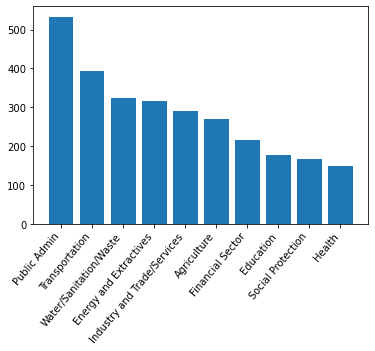

In [47]:
plt.plot(figsize=(8,8))
plt.bar(sector_counts.index, sector_counts.values)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

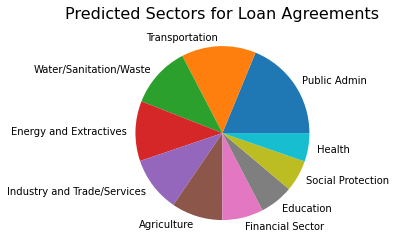

In [48]:
plt.plot(figsize=(12,12))
plt.pie(sector_counts.values,labels=sector_counts.index)
plt.title("Predicted Sectors for Loan Agreements",fontsize=16)
plt.show()

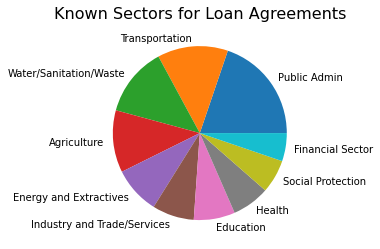

In [49]:
validated_sector_counts = labeled_set.major_sector_name.value_counts()
plt.plot(figsize=(12,12))
plt.pie(validated_sector_counts.values,labels=validated_sector_counts.index)
plt.title("Known Sectors for Loan Agreements",fontsize=16)
plt.show()

The distribution is roughly the same for the top 3 categories, and isn't too wildly off for the others. These seem like reasonable predictions.

Let's do some spot checks.

In [50]:
for idx, agreement in good_features.sample(20).iterrows():
    print(agreement['Project Name'], 'was classified as belonging to sector', agreement.predicted_sector)
    #print("Project Description:", agreement.project_desc[500:1000])
    print("Actual sector:", agreement.major_sector_name)
    print("\n\n")

Road Sector Capacity Development Project was classified as belonging to sector Transportation
Actual sector: Transportation



One Map Project was classified as belonging to sector Public Admin
Actual sector: nan



Second Privatization Social Support Project was classified as belonging to sector Public Admin
Actual sector: None



District Heating Project was classified as belonging to sector Energy and Extractives
Actual sector: nan



Structural Adjustment Loan was classified as belonging to sector Industry and Trade/Services
Actual sector: nan



Renewable Energy Small Power Project was classified as belonging to sector Energy and Extractives
Actual sector: None



Social Expenditure Management Project was classified as belonging to sector Education
Actual sector: Education



Yunnan Honghe Prefecture Diannan Center Urban Transport Project was classified as belonging to sector Transportation
Actual sector: Transportation



National Agricultural Extension and
Adaptive Research Proj

These seem like pretty reasonable predictions. We could probably check against sector2 and sector3 and get more agreement.

In [51]:
good_features.columns

Index(['id', 'Project Name', 'project_desc', 'project_name_lsi',
       'project_description_lsi', 'project_name_similarities_lsi',
       'description_similarities_lsi', 'sector_id', 'major_sector_name',
       'supervised_predictions', 'predicted_sector'],
      dtype='object')

In [52]:
good_features.drop(['project_name_lsi',
       'project_description_lsi', 'project_name_similarities_lsi',
       'description_similarities_lsi', 'project_desc'],axis=1).to_pickle('predicted_sectors_2.pkl')